# GEOS 5984: Geo Data Science with Python

# Final Project: Analysing patterns of Rainfall, Temperature, Drought and Ground Water Storage in South Asia

## Nazmul Huda

In this project, 4 different variables from 3 different datasets will be analyzed to look for pattern in the South Asian region. The datasets are, 
1. Global Land Data Assimilation System (GLDAS) (Rainfall & Temperature)
2. Standardized Precipitation Evapotranspiration Index (SPEI) (Drought)
3. Gravity Recovery and Climate Experiment (GRACE) (Ground water Storage)

In [1]:
#importing avriables and setting up the connection with NASA server

import geopandas as gpd
from shapely.geometry import Point, Polygon, mapping
from pydap.client import open_url
from pydap.cas.urs import setup_session
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm

username = 'nazmul0310' #username and password for NASA data
password = 'Peyal963258741'

In [2]:
#loading the shapefiles of the 8 countreis of South Asia

shapefile_afg = gpd.read_file('shapefiles/gadm41_AFG_0.shp')
shapefile_bgd = gpd.read_file('shapefiles/gadm41_BGD_0.shp')
shapefile_btn = gpd.read_file('shapefiles/gadm41_BTN_0.shp')
shapefile_ind = gpd.read_file('shapefiles/gadm41_IND_0.shp')
shapefile_lka = gpd.read_file('shapefiles/gadm41_LKA_0.shp')
shapefile_mdv = gpd.read_file('shapefiles/gadm41_MDV_0.shp')
shapefile_npl = gpd.read_file('shapefiles/gadm41_NPL_0.shp')
shapefile_pak = gpd.read_file('shapefiles/gadm41_PAK_0.shp')

# Bringing the shapefiles into common cordinate system

shapefile_afg = shapefile_afg.to_crs('EPSG:4326')
shapefile_bgd = shapefile_bgd.to_crs('EPSG:4326')
shapefile_btn = shapefile_btn.to_crs('EPSG:4326')
shapefile_ind = shapefile_ind.to_crs('EPSG:4326')
shapefile_lka = shapefile_lka.to_crs('EPSG:4326')
shapefile_mdv = shapefile_mdv.to_crs('EPSG:4326')
shapefile_npl = shapefile_npl.to_crs('EPSG:4326')
shapefile_pak = shapefile_pak.to_crs('EPSG:4326')

# Merge/Combine multiple shapefiles into one

south_asia_shape = gpd.pd.concat([shapefile_afg, shapefile_bgd, shapefile_btn, shapefile_ind, shapefile_lka, 
                                  shapefile_mdv, shapefile_npl, shapefile_pak])
 
#Export merged geodataframe into shapefile
south_asia_shape.to_file("south_asia_shape.shp")

In [3]:
# Solution to incorporate months

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
               'September', 'October', 'November', 'December']

years = [*range(2000, 2020, 1)]

#The list contains the month and year concatenated together,

monthsvalue = []

for y in years:
    for m in month_names:
        monthsvalue.append(m + ' ' + str(y))
        
monthsvalue = np.array(monthsvalue)

# Delineating the study area

<AxesSubplot:>

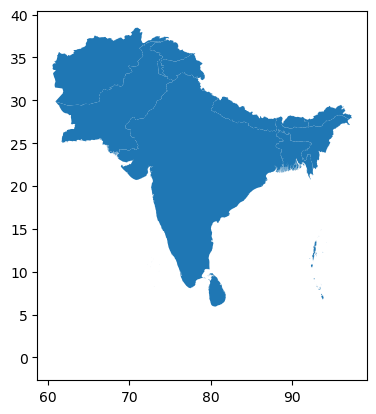

In [4]:
#First let's show the study area for the analysis but extended region has been kept

south_asia_shape.loc[:, 'geometry'].plot()

In [5]:
#the method of getting the data from the NASA server is not working for for some reason. 
#So, I am using the file from local 

# url1 = 'https://hydro1.gesdisc.eosdis.nasa.gov/thredds/ncss/GLDAS_aggregation/GLDAS_NOAH025_M.2.1/GLDAS_NOAH025_M.2.1_Aggregation.ncml?var=Rainf_tavg&var=Tair_f_inst&north=38&west=55&east=99&south=5&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2020-01-01T00%3A00%3A00Z&timeStride=1&accept=netcdf'
# session = setup_session(username, password, check_url=url) # create Earthdata session
# dataGLDAS = open_url(url1)  # create connection to dataset


#url2 = 'https://spei.csic.es/spei_database_2_7/nc/spei01.nc'
#speidata = open_url(url2,)


# url3 = 'http://download.csr.utexas.edu/outgoing/grace/RL06_mascons/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc'
# dataset = open_url(url3, session=session)


In [6]:
#getting data from 3 different sources
#the SPEI & GRACE datasets are larger than 100MB and can't be hosted in the github repo
#so the files after reading from here has been stored into npz files where data has been reduced highly

dataGLDAS = Dataset('GLDAS_NOAH025_M.2.1_Aggregation.ncml.nc')

fillvalue_GLDAS = dataGLDAS.variables['Tair_f_inst']._FillValue
lat_GLDAS = dataGLDAS.variables['lat'][:].data
lon_GLDAS = dataGLDAS.variables['lon'][:].data
time_GLDAS = dataGLDAS.variables['time'][0:240].data
airtemp = dataGLDAS.variables['Tair_f_inst'][0:240,:,:].data
airtemp = airtemp - 273.5
rainfall = dataGLDAS.variables['Rainf_tavg'][0:240,:,:].data
airtemp[airtemp < -200] = np.nan
rainfall[rainfall==fillvalue_GLDAS] = np.nan
airtemp_mask = dataGLDAS.variables['Tair_f_inst'][:].mask



## DO NOT RUN THE FOLLOWING CELL
### It saves the data into local memory, which has been done by the author

In [ ]:
#The data is loaded from local here and saves to npz files

speidata = Dataset('spei01.nc')
graceData = Dataset('CSR_GRACE_RL06_Mascons_v02.nc')

lat1spei = speidata.variables['lat'][180:300].data #getting a smaller region
lon1spei = speidata.variables['lon'][480:600].data #getting a smaller region
time1spei = speidata.variables['time'][1200:].data #filtering data for 2000 to 2020
spei1 = speidata.variables['spei'][1200:,180:300,480:600].data
fillvalue1spei = speidata.variables['spei']._FillValue
spei1[spei1==fillvalue1spei] = np.nan

glat1 = graceData.variables['lat'][360:600].data #getting a smaller region
glon1 = graceData.variables['lon'][240:480].data #getting a smaller region
gtime1 = graceData.variables['time'][2:].data #filtering data for 2018 to 2020
lwt1 = graceData.variables['lwe_thickness'][2:,360:600,240:480].data

##fillvalue1 = graceData.variables['lwe_thickness']._FillValue #not working for some reason

#storing the data so it works without spei01.nc file, as spei01.nc is a very large file
np.savez("spei_analysis.npz", spei1, lat1spei, lon1spei, time1spei, fillvalue1spei)
np.savez("grace_analysis.npz", lwt1, glat1, glon1, gtime1)

In [7]:
# loading the reduced data from the disk
data_coo = np.load("spei_analysis.npz")
data_coo2 = np.load("grace_analysis.npz")

#reloading the data
spei = data_coo['arr_0']
lat_spei = data_coo['arr_1']
lon_spei = data_coo['arr_2']
time_spei = data_coo['arr_3']
fillvalue_spei = data_coo['arr_4']

lwt = data_coo2['arr_0']
lat_grace = data_coo2['arr_1']
lon_grace = data_coo2['arr_2']
time_grace = data_coo2['arr_3']
#fillvalue_grace = data_coo['arr_4']
fillvalue_grace = 9.969209968386869e+36 #obtained from attributes information
lwt[lwt==fillvalue_grace] = np.nan

In [8]:
lonGrid_GLDAS, latGrid_GLDAS = np.meshgrid(lon_GLDAS,lat_GLDAS)
lonGrid_SPEI, latGrid_SPEI = np.meshgrid(lon_spei,lat_spei)
lonGrid_GRACE, latGrid_GRACE = np.meshgrid(lon_grace,lat_grace)

In [9]:
latMin = 6
latMax = 38
lonMin = 60.25 
lonMax = 98  

# # Finding indexes in the datasets that belong to the new boundaries
idx_latMax = np.argmin(np.abs(lat_GLDAS-latMax))
idx_latMin = np.argmin(np.abs(lat_GLDAS-latMin))
idx_lonMax = np.argmin(np.abs(lon_GLDAS-lonMax))
idx_lonMin = np.argmin(np.abs(lon_GLDAS-lonMin))

# # reducing the data and coordinate arrays to South Asia Coordinates
# # only adjusting coordinate dimensions, not the time dimension (first one)

airtemp_sa = airtemp[:,idx_latMin:idx_latMax,idx_lonMin:idx_lonMax]
rainfall_sa = rainfall[:,idx_latMin:idx_latMax,idx_lonMin:idx_lonMax]
lon_grid_gl = lonGrid_GLDAS[idx_latMin:idx_latMax,idx_lonMin:idx_lonMax]
lat_grid_gl = latGrid_GLDAS[idx_latMin:idx_latMax,idx_lonMin:idx_lonMax]

# # Finding indexes in the datasets that belong to the new boundaries
idx_latMax2 = np.argmin(np.abs(lat_spei-latMax))
idx_latMin2 = np.argmin(np.abs(lat_spei-latMin))
idx_lonMax2 = np.argmin(np.abs(lon_spei-lonMax))
idx_lonMin2 = np.argmin(np.abs(lon_spei-lonMin))

# # reducing the data and coordinate arrays to this frame
# # only adjusting coordinate dimensions, not the time dimension (first one)

spei_sa = spei[:,idx_latMin2:idx_latMax2,idx_lonMin2:idx_lonMax2]
lon_grid_spei = lonGrid_SPEI[idx_latMin2:idx_latMax2,idx_lonMin2:idx_lonMax2]
lat_grid_spei = latGrid_SPEI[idx_latMin2:idx_latMax2,idx_lonMin2:idx_lonMax2]

# # Finding indexes in the datasets that belong to the new boundaries
idx_latMax3 = np.argmin(np.abs(lat_grace-latMax))
idx_latMin3 = np.argmin(np.abs(lat_grace-latMin))
idx_lonMax3 = np.argmin(np.abs(lon_grace-lonMax))
idx_lonMin3 = np.argmin(np.abs(lon_grace-lonMin))

# # reducing the data and coordinate arrays to this frame
# # only adjusting coordinate dimensions, not the time dimension (first one)

lwt_sa = lwt[:,idx_latMin3:idx_latMax3,idx_lonMin3:idx_lonMax3]
lon_grid_grace = lonGrid_GRACE[idx_latMin3:idx_latMax3,idx_lonMin3:idx_lonMax3]
lat_grid_grace = latGrid_GRACE[idx_latMin3:idx_latMax3,idx_lonMin3:idx_lonMax3]

lenTimeSP = len(spei_sa[:,0,0])
lenLatSP = len(lat_spei)
lenLonSP = len(lon_spei)

lenTimeGR = len(lwt[:,0,0])
lenLatGR = len(lat_grace)
lenLonGR = len(lon_grace)

Text(0.5, 1.0, 'Air Temperature in South Asia, January 2000')

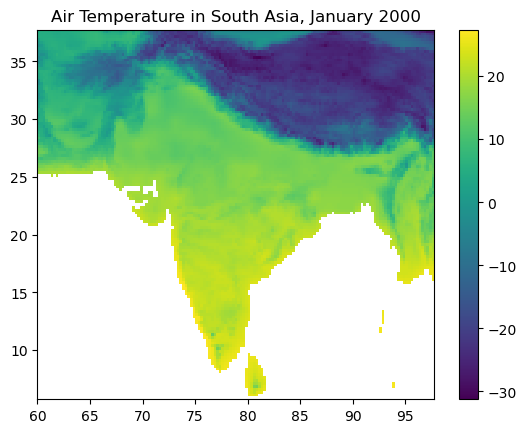

In [10]:
plt.pcolormesh(lon_grid_gl, lat_grid_gl, airtemp_sa[0],shading='auto') 
cbar = plt.colorbar()
plt.title('Air Temperature in South Asia, January 2000')

Text(0.5, 1.0, 'Rainfall in South Asia, July 2003')

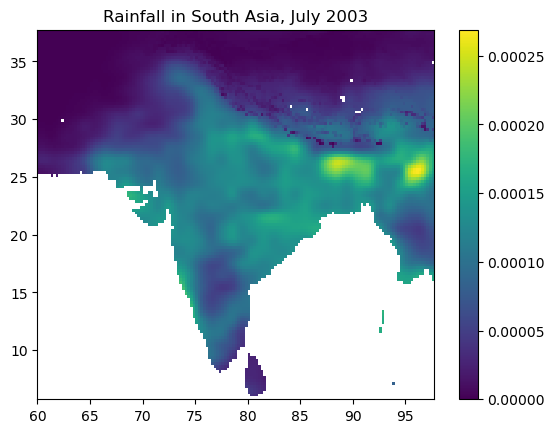

In [11]:
plt.pcolormesh(lon_grid_gl, lat_grid_gl, rainfall_sa[42],shading='auto') 
cbar = plt.colorbar()
plt.title('Rainfall in South Asia, July 2003')

Text(0.5, 1.0, 'SPEI in South Asia, January 2003')

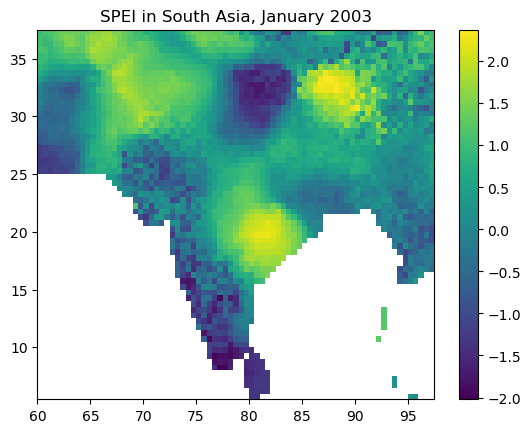

In [12]:
plt.pcolormesh(lon_grid_spei, lat_grid_spei, spei_sa[36],shading='auto') 
cbar = plt.colorbar()
plt.title('SPEI in South Asia, January 2003')

Text(0.5, 1.0, 'Ground Water in South Asia, January 2009')

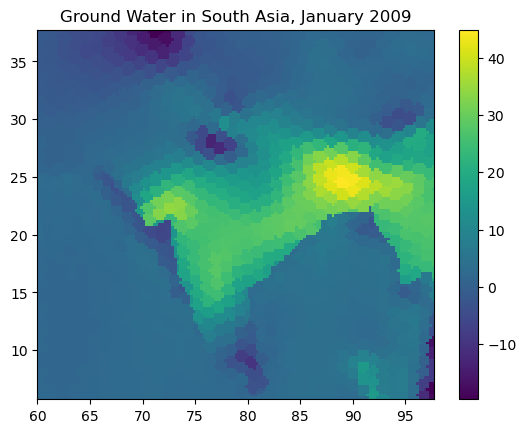

In [13]:
plt.pcolormesh(lon_grid_grace, lat_grid_grace, lwt_sa[60],shading='auto') 
cbar = plt.colorbar()
plt.title('Ground Water in South Asia, January 2009')

### Monthly Data Analysis

In [14]:
number_of_months = len(rainfall_sa[:,0,0])
months = np.arange(1,number_of_months + 1)

number_of_months_grace = len(lwt[:,0,0])
months_gr = np.arange(1,number_of_months_grace + 1)

In [15]:
monthly_temp = np.nanmean(airtemp_sa,axis=(1,2))
monthly_rain = np.nanmean(rainfall_sa,axis=(1,2))
monthly_drought = np.nanmean(spei_sa,axis=(1,2))
monthly_lwt = np.nanmean(lwt,axis=(1,2))

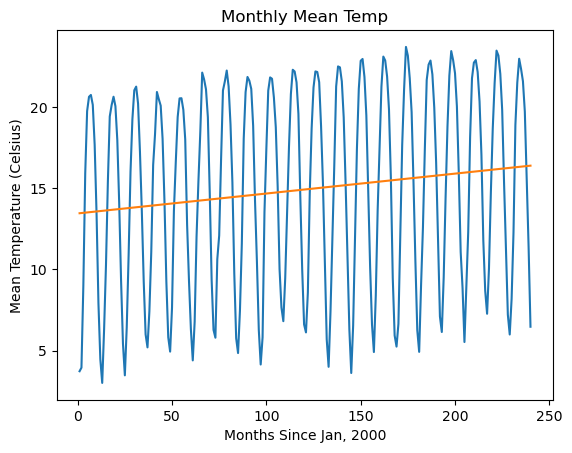

In [16]:
#Plots Mean Temperature
plt.plot(months, monthly_temp)
#calculate equation for trendline
z = np.polyfit(months, monthly_temp, 1)
p = np.poly1d(z)
plt.title('Monthly Mean Temp')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Mean Temperature (Celsius)')
#add trendline to plot
plt.plot(months, p(months))

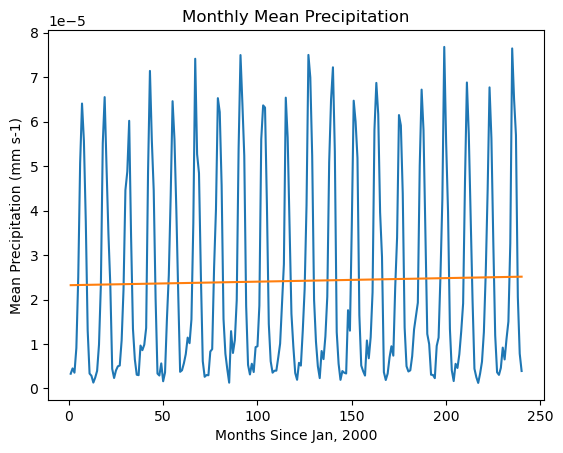

In [17]:
#Plots Mean Precipitation
plt.plot(months, monthly_rain)
#calculate equation for trendline
z = np.polyfit(months, monthly_rain, 1)
p = np.poly1d(z)
plt.title('Monthly Mean Precipitation')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Mean Precipitation (mm s-1)')
#add trendline to plot
plt.plot(months, p(months))

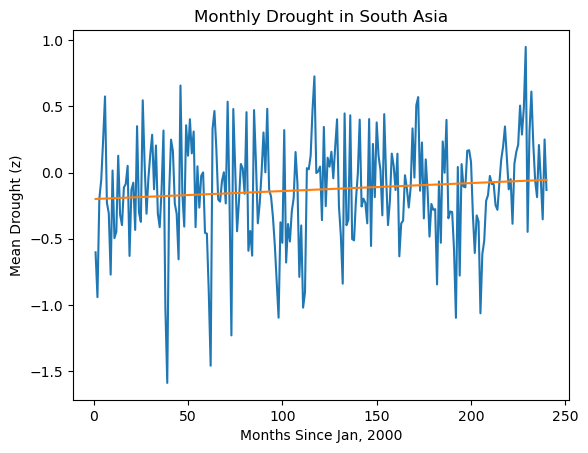

In [18]:
# #Plots Mean Drought
plt.plot(months, monthly_drought)
# #calculate equation for trendline
z = np.polyfit(months, monthly_drought, 1)
p = np.poly1d(z)
plt.title('Monthly Drought in South Asia')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Mean Drought (z)')
# #add trendline to plot
plt.plot(months, p(months))

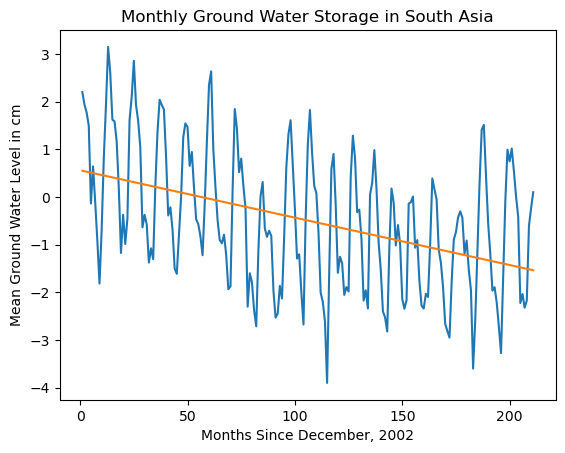

In [19]:
# #Plots Mean Ground Water Data
plt.plot(months_gr, monthly_lwt)
# #calculate equation for trendline
z = np.polyfit(months_gr, monthly_lwt, 1)
p = np.poly1d(z)
plt.title('Monthly Ground Water Storage in South Asia')
plt.xlabel('Months Since December, 2002')
plt.ylabel('Mean Ground Water Level in cm')
# #add trendline to plot
plt.plot(months_gr, p(months_gr))

### Exploratory Analysis for Max and Min Values of Temperature and Rainfall

In [20]:
# Month and year with lOWEST Precipitation

monthsvalue[np.argmin((monthly_rain))]

'January 2018'

In [21]:
# Month and year with Highest Precipitation

monthsvalue[np.argmax((monthly_rain))]

'July 2016'

In [22]:
# Month and year with Highest Temperature

monthsvalue[np.argmax((monthly_temp))]

'June 2014'

In [23]:
# Month and year with lOWEST Temperature

monthsvalue[np.argmin((monthly_temp))]

'January 2001'

### Analysis for Average Monthly Rainfall, Temperature, & Ground Water Storage

In [24]:
monthly_rain_jan = np.mean(monthly_rain[0::12])
monthly_rain_feb = np.mean(monthly_rain[1::12])
monthly_rain_mar = np.mean(monthly_rain[2::12])
monthly_rain_apr = np.mean(monthly_rain[3::12])
monthly_rain_may = np.mean(monthly_rain[4::12])
monthly_rain_jun = np.mean(monthly_rain[5::12])
monthly_rain_jul = np.mean(monthly_rain[6::12])
monthly_rain_aug = np.mean(monthly_rain[7::12])
monthly_rain_sep = np.mean(monthly_rain[8::12])
monthly_rain_oct = np.mean(monthly_rain[9::12])
monthly_rain_nov = np.mean(monthly_rain[10::12])
monthly_rain_dec = np.mean(monthly_rain[11::12])


monthly_temp_jan = np.mean(monthly_temp[0::12])
monthly_temp_feb = np.mean(monthly_temp[1::12])
monthly_temp_mar = np.mean(monthly_temp[2::12])
monthly_temp_apr = np.mean(monthly_temp[3::12])
monthly_temp_may = np.mean(monthly_temp[4::12])
monthly_temp_jun = np.mean(monthly_temp[5::12])
monthly_temp_jul = np.mean(monthly_temp[6::12])
monthly_temp_aug = np.mean(monthly_temp[7::12])
monthly_temp_sep = np.mean(monthly_temp[8::12])
monthly_temp_oct = np.mean(monthly_temp[9::12])
monthly_temp_nov = np.mean(monthly_temp[10::12])
monthly_temp_dec = np.mean(monthly_temp[11::12])

monthly_lwt_jan = np.mean(monthly_lwt[1::12])
monthly_lwt_feb = np.mean(monthly_lwt[2::12])
monthly_lwt_mar = np.mean(monthly_lwt[3::12])
monthly_lwt_apr = np.mean(monthly_lwt[4::12])
monthly_lwt_may = np.mean(monthly_lwt[5::12])
monthly_lwt_jun = np.mean(monthly_lwt[6::12])
monthly_lwt_jul = np.mean(monthly_lwt[7::12])
monthly_lwt_aug = np.mean(monthly_lwt[8::12])
monthly_lwt_sep = np.mean(monthly_lwt[9::12])
monthly_lwt_oct = np.mean(monthly_lwt[10::12])
monthly_lwt_nov = np.mean(monthly_lwt[11::12])
monthly_lwt_dec = np.mean(monthly_lwt[0::12])

In [25]:
list_monthly_mean_rainfall = [monthly_rain_jan, monthly_rain_feb, monthly_rain_mar, monthly_rain_apr, monthly_rain_may,
                              monthly_rain_jun, monthly_rain_jul, monthly_rain_aug, monthly_rain_sep, monthly_rain_oct,
                              monthly_rain_nov, monthly_rain_dec]


list_monthly_mean_temp = [monthly_temp_jan, monthly_temp_feb, monthly_temp_mar, monthly_temp_apr, monthly_temp_may, 
                          monthly_temp_jun, monthly_temp_jul, monthly_temp_aug, monthly_temp_sep, monthly_temp_oct,
                          monthly_temp_nov, monthly_temp_dec]

list_monthly_mean_lwt = [monthly_lwt_jan, monthly_lwt_feb, monthly_lwt_mar, monthly_lwt_apr, monthly_lwt_may,
                         monthly_lwt_jun, monthly_lwt_jul, monthly_lwt_aug, monthly_lwt_sep, monthly_lwt_oct,
                         monthly_lwt_nov, monthly_lwt_dec]

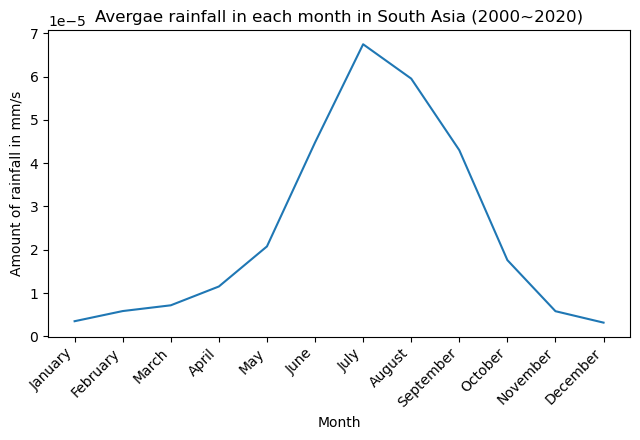

In [26]:
# plt.plot(list_monthly_mean_rainfall)

plt.rcParams["figure.figsize"] = [6.50, 4.50]
plt.rcParams["figure.autolayout"] = True
plt.xlabel('Month')
plt.ylabel('Amount of rainfall in mm/s')
plt.title('Avergae rainfall in each month in South Asia (2000~2020)')
default_x_ticks = range(len(list_monthly_mean_rainfall))
plt.plot(default_x_ticks, list_monthly_mean_rainfall)
plt.xticks(default_x_ticks,month_names,rotation=45, ha='right')
plt.show()

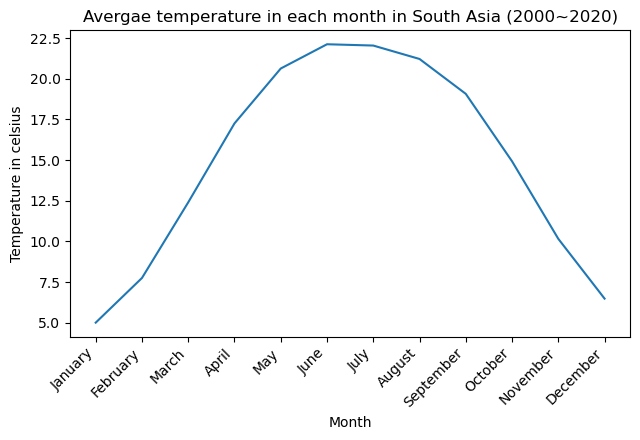

In [27]:
# plt.plot(list_monthly_mean_rainfall)

plt.rcParams["figure.figsize"] = [6.50, 4.50]
plt.rcParams["figure.autolayout"] = True
plt.xlabel('Month')
plt.ylabel('Temperature in celsius')
plt.title('Avergae temperature in each month in South Asia (2000~2020)')
default_x_ticks = range(len(list_monthly_mean_temp))
plt.plot(default_x_ticks, list_monthly_mean_temp)
plt.xticks(default_x_ticks,month_names,rotation=45, ha='right')
plt.show()

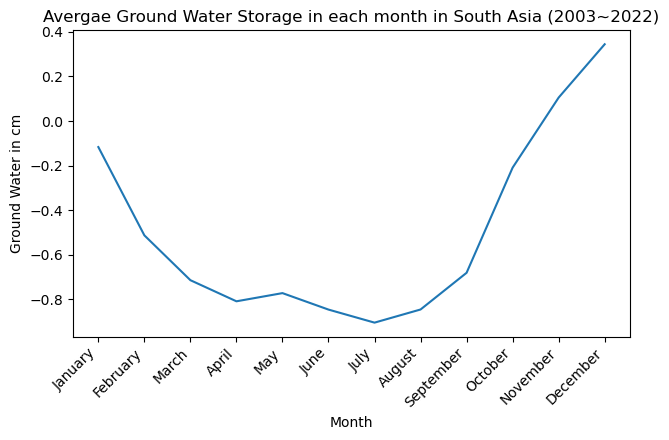

In [28]:
plt.rcParams["figure.figsize"] = [6.50, 4.50]
plt.rcParams["figure.autolayout"] = True
plt.xlabel('Month')
plt.ylabel('Ground Water in cm')
plt.title('Avergae Ground Water Storage in each month in South Asia (2003~2022)')
default_x_ticks = range(len(list_monthly_mean_lwt))
plt.plot(default_x_ticks, list_monthly_mean_lwt)
plt.xticks(default_x_ticks,month_names,rotation=45, ha='right')
plt.show()

### Investigating the important times of the year

Text(0, 0.5, 'Mean Precipitation (kg m-2 s-1)')

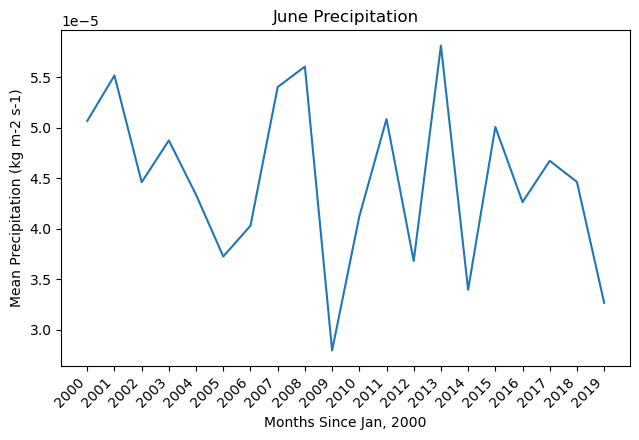

In [29]:
#Plots June Precipitations since 2000
#plt.rcParams["figure.figsize"] = [6.50, 4.50]
#plt.rcParams["figure.autolayout"] = True
default_x_ticks = range(len(years))
plt.plot(default_x_ticks, monthly_rain[5::12])
plt.xticks(default_x_ticks,years,rotation=45, ha='right')

#calculate equation for trendline
z = np.polyfit(months[5::12], monthly_rain[5::12], 1)
p = np.poly1d(z)
plt.title('June Precipitation')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Mean Precipitation (kg m-2 s-1)')

#add trendline to plot
#trend line & TICKS with month names together disrupts the chart, I have no idea why, trend line has been drawn in the 
#figure below but that misses the year values
#plt.plot(months[5::12], p(months[5::12]))

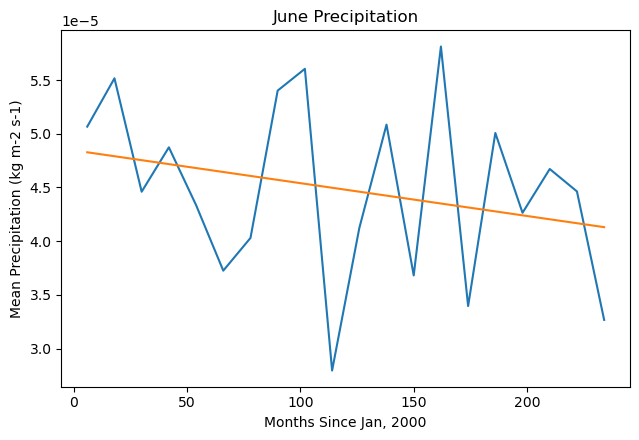

In [30]:
#Plots June Precipitations since 2000
plt.plot(months[5::12], monthly_rain[5::12])
#calculate equation for trendline
z = np.polyfit(months[5::12], monthly_rain[5::12], 1)
p = np.poly1d(z)
plt.title('June Precipitation')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Mean Precipitation (kg m-2 s-1)')
#add trendline to plot
plt.plot(months[5::12], p(months[5::12]))

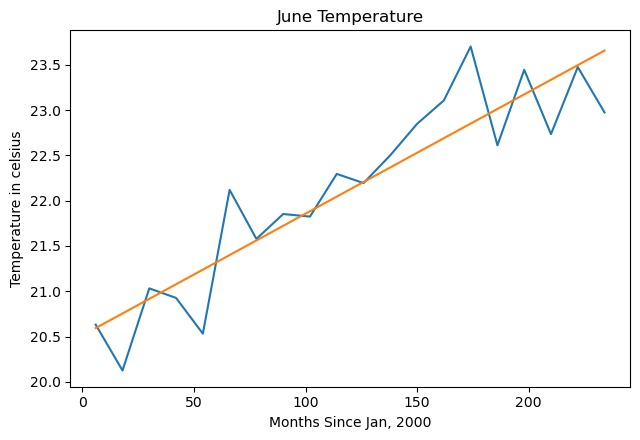

In [31]:
#Plots June Temperature since 2000
plt.plot(months[5::12], monthly_temp[5::12])
#calculate equation for trendline
z = np.polyfit(months[5::12], monthly_temp[5::12], 1)
p = np.poly1d(z)
plt.title('June Temperature')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Temperature in celsius')
#add trendline to plot
plt.plot(months[5::12], p(months[5::12]))

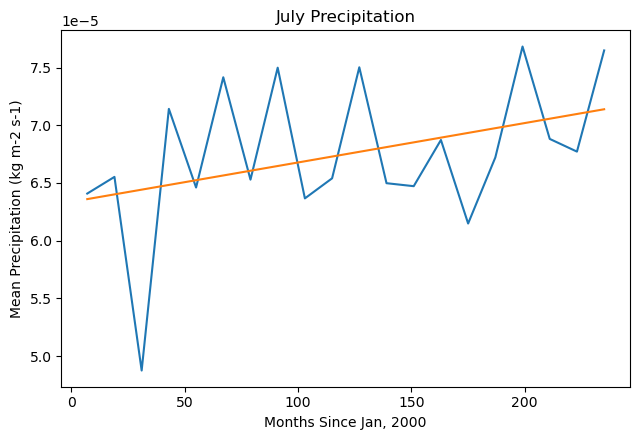

In [32]:
#Plots July Precipitations since 2000
plt.plot(months[6::12], monthly_rain[6::12])
#calculate equation for trendline
z = np.polyfit(months[6::12], monthly_rain[6::12], 1)
p = np.poly1d(z)
plt.title('July Precipitation')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Mean Precipitation (kg m-2 s-1)')
#add trendline to plot
plt.plot(months[6::12], p(months[6::12]))

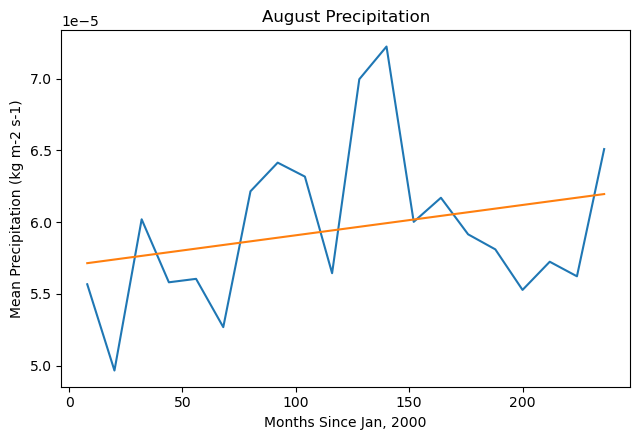

In [33]:
#Plots August Precipitations since 2000
plt.plot(months[7::12], monthly_rain[7::12])
#calculate equation for trendline
z = np.polyfit(months[7::12], monthly_rain[7::12], 1)
p = np.poly1d(z)
plt.title('August Precipitation')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Mean Precipitation (kg m-2 s-1)')
#add trendline to plot
plt.plot(months[7::12], p(months[7::12]))

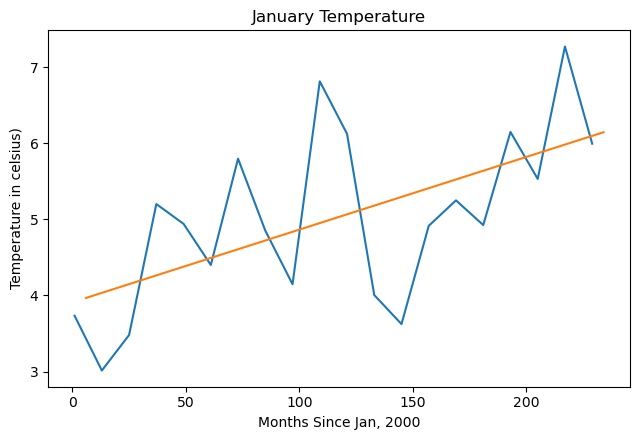

In [34]:
#Plots January Temperature since 2000
plt.plot(months[0::12], monthly_temp[0::12])
#calculate equation for trendline
z = np.polyfit(months[0::12], monthly_temp[0::12], 1)
p = np.poly1d(z)
plt.title('January Temperature')
plt.xlabel('Months Since Jan, 2000')
plt.ylabel('Temperature in celsius)')
#add trendline to plot
plt.plot(months[5::12], p(months[5::12]))

# Principal Component Analysis

## Analysis with GRACE Data

In [35]:
# reshapes 3D data array to 2D big data matrix X:
X = lwt.reshape((lenTimeGR,lenLonGR*lenLatGR))
X = np.transpose(X) # transpose so that spatial components on rows and temporal measurement on columns of X
print('Size of X: ',X.shape)

Size of X:  (57600, 211)


In [36]:
# Find and save index location of nan/notnan values in X (land areas) in a 1D array
#    Note: will do this only for the first column/time step, 
#    because mask is the same for every time step
Xnan = np.where(np.isnan(X[:,0]))[0]    # index location of nan values
Xnotnan= np.where(~np.isnan(X[:,0]))[0] # index location of non-nan values 

print('Number of nan/land values in one column of X: ',len(Xnan))
print('Number of not-nan/ocean values in one column of X: ',len(Xnotnan))
print('\nIndex location of nan values:')
Xnan

Number of nan/land values in one column of X:  0
Number of not-nan/ocean values in one column of X:  57600

Index location of nan values:


array([], dtype=int64)

In [37]:
# Delete nan/land values from X in all columns, store in X1
X1 = X[Xnotnan] # filter out land values, via fancy indexing !
# note: Xnotnan indicees are broadcasted along time axis
print('Size of X1: ', X1.shape) 

Size of X1:  (57600, 211)


In [38]:
#Perform SVD with nan-filtered big matrix X1
u1,s,vT = np.linalg.svd(X1,full_matrices=0) # performs the singular value decomposition

In [39]:
# This block of code restores spatial values to a full matrix, with the land areas restored as nans
u = np.ones((lenLonGR*lenLatGR,lenTimeGR))  # create empty array of size of originial X (having space for land/nan cells)
u[Xnan,:] = np.nan   # setting all land values to nan
u[Xnotnan,:] = u1      # refill ocean values with results from u
print('Size of u: ', u.shape) 

Size of u:  (57600, 211)


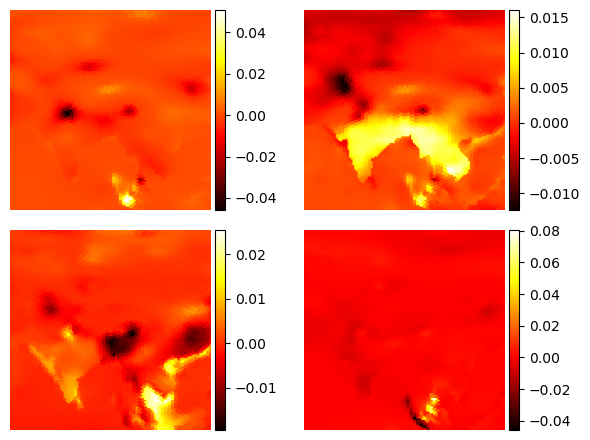

In [40]:
# plots the main features  from the svd
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)  # reshapes axes array into a 1d array (for easier indexing)
for j in range(4):
    U = np.flipud(np.reshape(u[:,j],(lenLatGR,lenLonGR))) # reshape u-columns (1D) to maps (2D array) 
    U2 = U[::2,::2]  # slice out every second pixel to reduce image size (will plot faster)
    im = axs[j].imshow(U2,cmap='hot')
    axs[j].axis('off')
    # following lines add colorbar to each subplot
    divider = make_axes_locatable(axs[j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical');

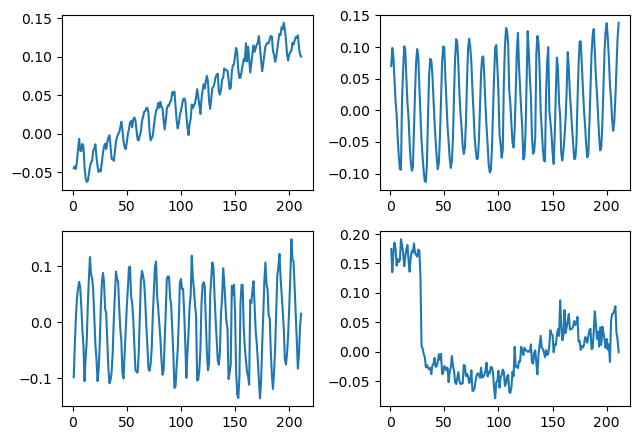

In [41]:
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for j in range(4):
    V = vT[j,:]
    im = axs[j].plot(range(1,len(V)+1),V)

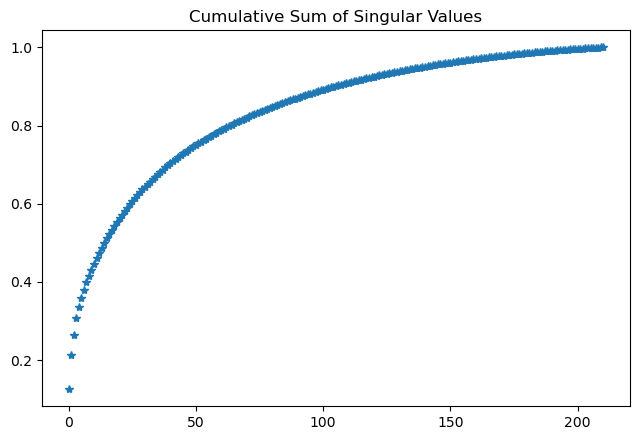

In [42]:
plt.figure()
plt.plot(np.cumsum(s)/np.sum(s),'*')
plt.title('Cumulative Sum of Singular Values')
plt.show()

## Analysis with GLDAS Rainfall Data

In [43]:
lenTime = len(rainfall[:,0,0])
lenLat = len(lat_GLDAS)
lenLon = len(lon_GLDAS)

In [44]:
# reshapes 3D data array to 2D big data matrix X:
X = rainfall.reshape((lenTime,lenLon*lenLat))
X = np.transpose(X) # transpose so that spatial components on rows and temporal measurement on columns of X
print('Size of X: ',X.shape)

Size of X:  (23541, 240)


In [45]:
# Find and save index location of nan/notnan values in X (land areas) in a 1D array
#    Note: will do this only for the first column/time step, 
#    because mask is the same for every time step
Xnan = np.where(np.isnan(X[:,0]))[0]    # index location of nan values
Xnotnan= np.where(~np.isnan(X[:,0]))[0] # index location of non-nan values 

print('Number of nan/land values in one column of X: ',len(Xnan))
print('Number of not-nan/ocean values in one column of X: ',len(Xnotnan))
print('\nIndex location of nan values:')
Xnan

Number of nan/land values in one column of X:  9999
Number of not-nan/ocean values in one column of X:  13542

Index location of nan values:


array([    0,     1,     2, ..., 19075, 20140, 21233], dtype=int64)

In [46]:
# Delete nan/land values from X in all columns, store in X1
X1 = X[Xnotnan] # filter out land values, via fancy indexing !
# note: Xnotnan indicees are broadcasted along time axis
print('Size of X1: ', X1.shape) 

Size of X1:  (13542, 240)


In [47]:
#Perform SVD with nan-filtered big matrix X1
u1,s,vT = np.linalg.svd(X1,full_matrices=0) # performs the singular value decomposition

In [48]:
# This block of code restores spatial values to a full matrix, with the land areas restored as nans
u = np.ones((lenLon*lenLat,lenTime))  # create empty array of size of originial X (having space for land/nan cells)
u[Xnan,:] = np.nan   # setting all land values to nan
u[Xnotnan,:] = u1      # refill ocean values with results from u
print('Size of u: ', u.shape) 

Size of u:  (23541, 240)


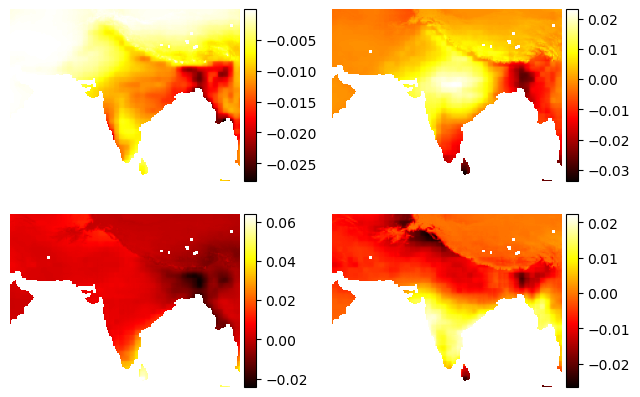

In [49]:
# plots the main features  from the svd
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)  # reshapes axes array into a 1d array (for easier indexing)
for j in range(4):
    U = np.flipud(np.reshape(u[:,j],(lenLat,lenLon))) # reshape u-columns (1D) to maps (2D array) 
    U2 = U[::1,::1]  # slice out every second pixel to reduce image size (will plot faster)
    im = axs[j].imshow(U2,cmap='hot')
    axs[j].axis('off')
    # following lines add colorbar to each subplot
    divider = make_axes_locatable(axs[j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical');

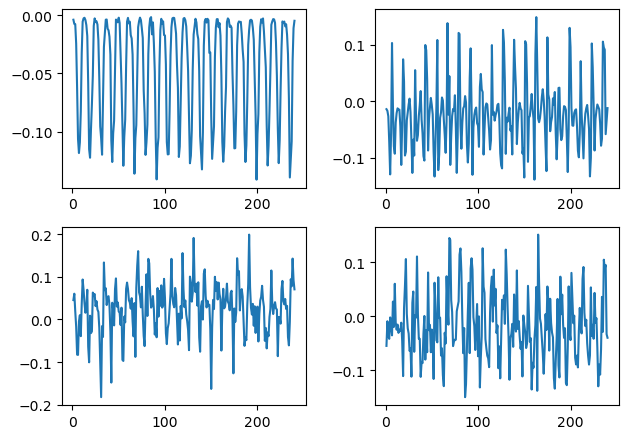

In [50]:
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for j in range(4):
    V = vT[j,:]
    im = axs[j].plot(range(1,len(V)+1),V)

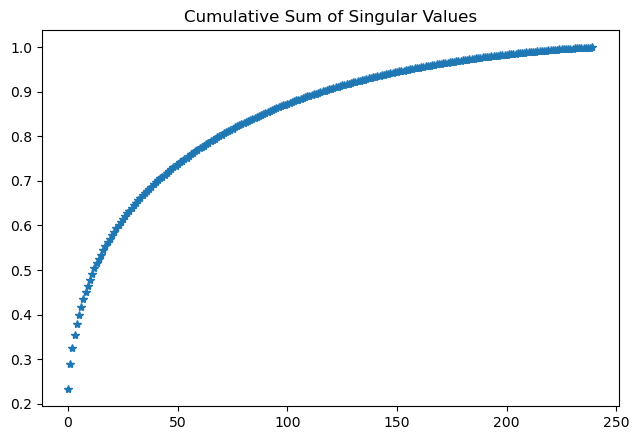

In [51]:
plt.figure()
plt.plot(np.cumsum(s)/np.sum(s),'*')
plt.title('Cumulative Sum of Singular Values')
plt.show()

## Analysis with GLDAS Temperature Data

In [52]:
# reshapes 3D data array to 2D big data matrix X:
X = airtemp.reshape((lenTime,lenLon*lenLat))
X = np.transpose(X) # transpose so that spatial components on rows and temporal measurement on columns of X
print('Size of X: ',X.shape)

Size of X:  (23541, 240)


In [53]:
# Find and save index location of nan/notnan values in X (land areas) in a 1D array
#    Note: will do this only for the first column/time step, 
#    because mask is the same for every time step
Xnan = np.where(np.isnan(X[:,0]))[0]    # index location of nan values
Xnotnan= np.where(~np.isnan(X[:,0]))[0] # index location of non-nan values 

print('Number of nan/land values in one column of X: ',len(Xnan))
print('Number of not-nan/ocean values in one column of X: ',len(Xnotnan))
print('\nIndex location of nan values:')
Xnan

Number of nan/land values in one column of X:  9967
Number of not-nan/ocean values in one column of X:  13574

Index location of nan values:


array([    0,     1,     2, ..., 15406, 15581, 15582], dtype=int64)

In [54]:
# Delete nan/land values from X in all columns, store in X1
X1 = X[Xnotnan] # filter out land values, via fancy indexing !
# note: Xnotnan indicees are broadcasted along time axis
print('Size of X1: ', X1.shape) 

Size of X1:  (13574, 240)


In [55]:
#Perform SVD with nan-filtered big matrix X1
u1,s,vT = np.linalg.svd(X1,full_matrices=0) # performs the singular value decomposition

In [56]:
# This block of code restores spatial values to a full matrix, with the land areas restored as nans
u = np.ones((lenLon*lenLat,lenTime))  # create empty array of size of originial X (having space for land/nan cells)
u[Xnan,:] = np.nan   # setting all land values to nan
u[Xnotnan,:] = u1      # refill ocean values with results from u
print('Size of u: ', u.shape) 

Size of u:  (23541, 240)


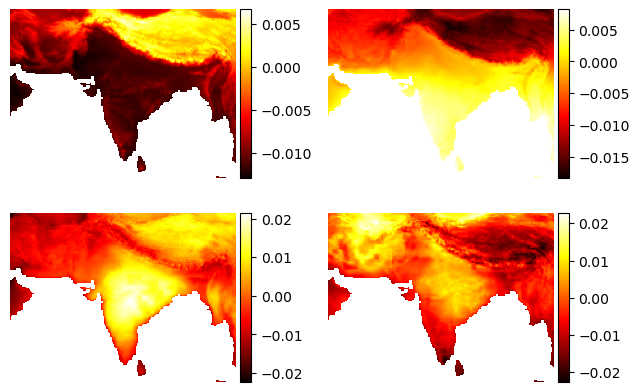

In [57]:
# plots the main features  from the svd
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)  # reshapes axes array into a 1d array (for easier indexing)
for j in range(4):
    U = np.flipud(np.reshape(u[:,j],(lenLat,lenLon))) # reshape u-columns (1D) to maps (2D array) 
    U2 = U[::1,::1]  # slice out every second pixel to reduce image size (will plot faster)
    im = axs[j].imshow(U2,cmap='hot')
    axs[j].axis('off')
    # following lines add colorbar to each subplot
    divider = make_axes_locatable(axs[j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical');

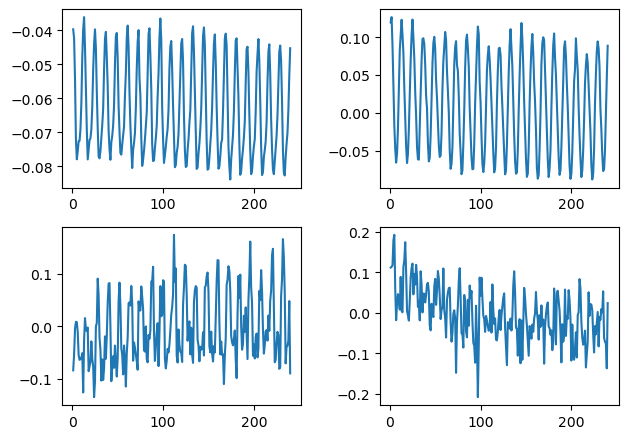

In [58]:
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for j in range(4):
    V = vT[j,:]
    im = axs[j].plot(range(1,len(V)+1),V)

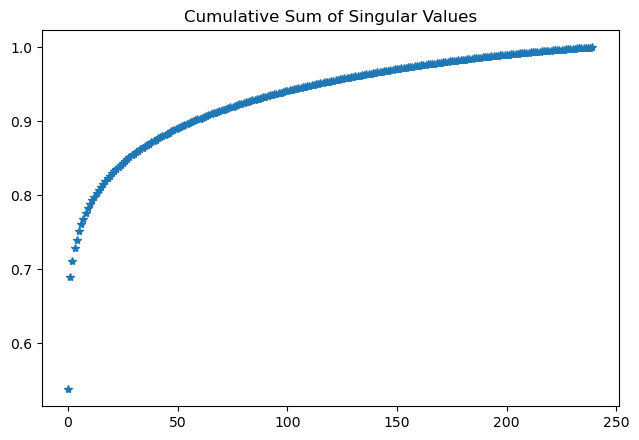

In [59]:
plt.figure()
plt.plot(np.cumsum(s)/np.sum(s),'*')
plt.title('Cumulative Sum of Singular Values')
plt.show()

### In this report, the GRACE data and Ground Water Storage has not been processed for the missing data points and simply gives an overall idea of the ground water distribution over space and time recognizing the error in data